# Analyse Interval Analysis

In [321]:
from pathlib import Path
import pandas as pd
from matplotlib import pyplot as plt
import re

Run with `dakota -i ia.in`.

In [322]:
# Remove LHS* files
lhs_paths = Path.cwd().glob("LHS*")
for lhs_path in lhs_paths:
    lhs_path.unlink()

In [323]:
# Collect interval results (w response) and constraint numbers that are min and max w
out_paths = ["ia_lt_8p.out", "ia_lt_max_q_8p.out"]
# out_paths = ["ia_lt_1p.out"]  # testing
intervals = {"design": [], "min": [], "max": [], "min_con_id": [], "max_con_id": []}
design_names = {
    # "ia_lt_1p": "test",
    "ia_lt_8p": "$\min R_{major}$",
    "ia_lt_max_q_8p": "$\max Q$",
}
con_ids = {
    5: "Density upper limit",
    13: "Burn time lower limit",
    15: "L-H power threshold limit",
    16: "Net electric power lower limit",
    34: "TF coil dump voltage upper limit (SCTF)",
}
min_max_re = re.compile(r"w:\s+Min\s=\s(-?\d\.\d+e[+-]\d+)\s+Max\s=\s(\d\.\d+e[+-]\d+)")
w_con_id_re = re.compile(r"\s+(\d\.\d+e[+-]\d+)\s+w\n\s+\s(\d\.\d+e[+-]\d+)\sw_con_id")
for results_path in [Path(out_path) for out_path in out_paths]:
    # Extract min and max
    with open(results_path, "r") as f:
        # Might be a problem with huge files? Seems alright
        text = f.read()

    # Find min and max values of w (in results summary)
    min_max_matches = min_max_re.search(text)
    min = min_max_matches[1]
    max = min_max_matches[2]

    # Now find constraint id corresponding to w
    # Finds all w values and their corresponding con ids (numbers)
    w_con_id_matches = w_con_id_re.findall(text)
    for w_con_id_match in w_con_id_matches:
        if w_con_id_match[0] == min:
            # min w con id
            min_con_id = int(float(w_con_id_match[1]))
        elif w_con_id_match[0] == max:
            # max w con id
            max_con_id = int(float(w_con_id_match[1]))

    # Aggregate data for df
    intervals["design"].append(design_names[results_path.stem])
    intervals["min"].append(float(min))
    intervals["max"].append(float(max))
    intervals["min_con_id"].append(con_ids[min_con_id])
    intervals["max_con_id"].append(con_ids[max_con_id])

df = pd.DataFrame(intervals)
df

,design,min,max,min_con_id,max_con_id
0,$\min R_{major}$,-1.554312e-15,101071.12936,Density upper limit,L-H power threshold limit
1,$\max Q$,-1.976060e-06,140522.51854,Density upper limit,L-H power threshold limit


/tmp/ipykernel_155029/1190157479.py:16: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  ax.axvline(x=0.0, linestyle="--", color="grey")


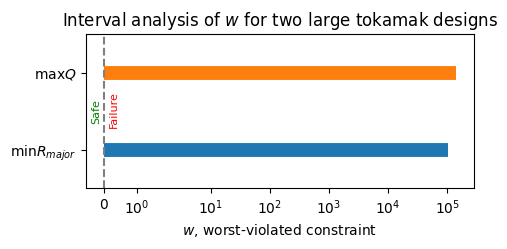

In [324]:
# Custom plot
fig, ax = plt.subplots(figsize=(5, 2.0))
for i, row in df.iterrows():
    ax.hlines(
        y=row["design"],
        xmin=row["min"],
        xmax=row["max"],
        color=f"C{i}",
        linewidth=10,
    )

ax.set_xlabel("$w$, worst-violated constraint")
ax.set_title("Interval analysis of $w$ for two large tokamak designs")
ax.margins(y=0.5)
ax.set_xscale("symlog")
ax.axvline(x=0.0, linestyle="--", color="grey")
ax.annotate(
    "Safe",
    xy=(0.0, 0.0),
    xytext=(-9, 20),
    textcoords="offset points",
    rotation=90,
    size=8,
    color="g",
)
ax.annotate(
    "Failure",
    xy=(0.0, 0.0),
    xytext=(4, 17),
    textcoords="offset points",
    rotation=90,
    size=8,
    color="r",
)
plt.savefig("ia.pdf", bbox_inches="tight")

/tmp/ipykernel_155029/1750809942.py:49: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  axes[0].axvline(x=0.0, linestyle="--", color="grey")


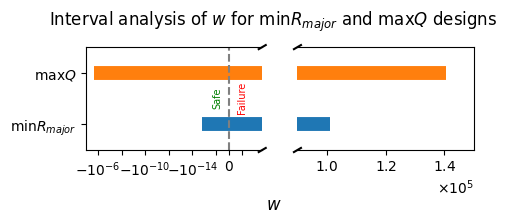

In [325]:
# Same plot with broken axes
fig, axes = plt.subplots(1, 2, sharey=TabError, figsize=(5, 2.1))
for ax in axes:
    for i, row in df.iterrows():
        ax.hlines(
            y=row["design"],
            xmin=row["min"],
            xmax=row["max"],
            color=f"C{i}",
            linewidth=10,
        )

# Limit view to different portions of data
axes[0].set_xscale("symlog", linthresh=1.0e-16)
axes[0].set_xlim(-1.0e-5, 5.0e-15)
axes[0].spines["right"].set_visible(False)
axes[0].yaxis.tick_left()
axes[1].spines["left"].set_visible(False)
axes[1].set_xlim(9e4, 1.5e5)
axes[1].tick_params(labelleft=False)
axes[1].yaxis.tick_right()

# Hide odd tick labels to avoid overlaps
for label in axes[0].xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

axes[1].ticklabel_format(axis="x", style="sci", scilimits=(0, 0), useMathText=True)

d = 0.02  # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=axes[0].transAxes, color="k", clip_on=False)
axes[0].plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
axes[0].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
kwargs.update(transform=axes[1].transAxes)  # switch to the bottom axes
axes[1].plot((-d, +d), (-d, +d), **kwargs)  # top-left diagonal
axes[1].plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal

axes[1].axes.get_yaxis().set_visible(False)

# Avoid suptitle and sublabel axes overlaps
plt.subplots_adjust(top=0.80)
plt.subplots_adjust(bottom=0.31)


# Pre-existing
fig.supxlabel("$w$")
fig.suptitle("Interval analysis of $w$ for $\min R_{major}$ and $\max Q$ designs")
axes[0].margins(y=0.5)
axes[1].margins(y=0.5)
axes[0].axvline(x=0.0, linestyle="--", color="grey")
axes[0].annotate(
    "Safe",
    xy=(0.0, 0.0),
    xytext=(-12, 13),
    textcoords="offset points",
    rotation=90,
    size=7,
    color="g",
)
axes[0].annotate(
    "Failure",
    xy=(0.0, 0.0),
    xytext=(6, 9),
    textcoords="offset points",
    rotation=90,
    size=7,
    color="r",
)
plt.savefig("ia.pdf", bbox_inches="tight")

In [326]:
col_map = {
    "design": "Design",
    "min": "LB",
    "max": "UB",
    "min_con_id": "Limiting LB constraint",
    "max_con_id": "Limiting UB constraint",
}
latex_df = df.rename(columns=col_map)
latex_df

,Design,LB,UB,Limiting LB constraint,Limiting UB constraint
0,$\min R_{major}$,-1.554312e-15,101071.12936,Density upper limit,L-H power threshold limit
1,$\max Q$,-1.976060e-06,140522.51854,Density upper limit,L-H power threshold limit


In [327]:
latex_df.to_latex(
    "w_intervals.tex",
    float_format="%.2e",
    index=False,
    # column_format="llrrp{0.45\linewidth}",
)